# Introduction

The current work is a STUDY project in the frame of SOFTUNI Machile Learning course, led by Dr. Jordan Darakchiev.
The goal is to explore different Machine Learning Algorithms, learning from a higly imbalanced dataset.
Such datasets are a common case in the field of predictive maintenance. The process failures have a very strong impact on the bottom line of manufacturing companies. Predicting such failures could affect the whole production process and improve the companies performance.

This work pursues the following steps:
1. Train the most simple and the most powerful (to our knowledge) ML models.
2. Compare their metrics and choose the best performing model.
3. Perform fine-tunning of the best model.
4. Employ some different models for comparison.
5. Draw a conclusion.

For the sake of curiosity, different classification metrics (Accuracy, Precision, Recall, F1 score) are reported. However, the most important for predictive maintenance is the sensitivity of the model, i.e. Recall. For this reason,  Fbeta, beta=2 is also considered.

In this case study, only models with a Fbeta score more than 0.90 (or 90%) have practical importance.

# Content
- [ Code ](#1)
- [ Data Input](#2)
- [ Data Exploration](#3)
- [ Data Cleaning](#4)
- [ Assigning variables](#5)
- [ Scaling independent varaibles](#6)
- [ Splitting the dataset](#7)
- [ Binary classification - Logistic regression](#8)
- [ Binary Calssification - Gradient Boosting](#9)
- [ Binary Calssification - XGBoost](#10)
- [ Comparison of all models](#11)
- [ Tunning the best model](#12)
- [ Comparative approaches](#13)
- [ Conclusion](#14)
- [ References](#15)


<a name="1"></a>
# Code

## Libraries

In [1]:
import os
import mlflow
import numpy as np
import math

import matplotlib.pyplot as plt
import pandas as pd
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn import metrics
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score, fbeta_score
from sklearn.metrics import auc, roc_curve
from sklearn.metrics import ConfusionMatrixDisplay

In [2]:
%matplotlib inline


## Functions

To avoid code repetion, the following display fuctions are implemented: plot_conf_matix, print_classification_metrics, plot_ROC

In [3]:
def plot_conf_matrix(model,X,y, i=None):
    """ Plots confusion matrix.
    Args: 
          model (object): ML model
          X (ndarray (m,n): Data, m examples with n features
          y (ndarray (m,)): target values
          
          i (scalar): numnber of plot in muliplot (None or int)
    Return:
          matplotlib plot
    """
    y_pred=model.predict(X)
    y_true=y
    mod=metrics.confusion_matrix(y_true, y_pred, labels=model.classes_)
    disp = ConfusionMatrixDisplay(confusion_matrix=mod, display_labels=model.classes_) # Create a ConfusionMatrixDisplay
    if i in [0,1,2,3,4,5]: # check if fucnction is used in subplots
        return disp.plot(ax=axs[i])
    return disp.plot()


def print_classification_metrics(model, X, y, mode='show'):
    """ Prints accuracy, precision, recall, f1, fbeta
    Args: 
          model (object): ML model
          X (ndarray (m,n): Data, m examples with n features
          y (ndarray (m,)): target values
          
          mode (str): 'show' if you want to print, or
                      'tuple' if you want to return a tuple, default='show'
    Returns: 
          None if mode='show'
          tuple (accuracy, precision, recall, f1, fbeta) if mode='tuple'
    """
    y_pred = model.predict(X)
    ac=accuracy_score(y, y_pred)
    pr=precision_score(y, y_pred, average = 'binary')
    rc=recall_score(y, y_pred, average = 'binary')
    f1=f1_score(y, y_pred, average = 'binary')
    f_beta=fbeta_score(y, y_pred, beta=2, average = 'binary')
    if mode=='show':    # check in what mode the function is called
        print(f'Accuracy: {ac:.3f}')
        print(f"Precision: {pr:.3f}")
        print(f"Recall: {rc:.3f}")
        print(f"F1 score: {f1:.3f}")
        print(f"Fbeta score (beta=2): {f_beta:.3f}")
    else:
        return ac,pr,rc,f1,f_beta
    

def plot_ROC(model, X, y, i=None):
    """ Plot ROC curve with AUC value
    Args: 
          model (object): ML model
          X (ndarray (m,n): Data, m examples with n features
          y (ndarray (m,)): target values
          
          i (scalar)- index of plots in muliplot (None or 0,1,2,3,4,5, default=None, ) 
    Return: 
          None
    """
    # Predict the probabilities of the positive class
    y_pred = model.predict_proba(X)[:,1]


    # Calculate the ROC curve
    fpr, tpr, thresholds = roc_curve(y, y_pred)

    # Calculate the AUC score
    auc_score = auc(fpr, tpr)
    x1=np.linspace(0,1,100)
    # Plot the ROC curve
    if i in [0,1,2,3,4,5]:   # check if fucnction is used in subplots
        axs[i].plot(fpr, tpr, label=f"ROC curve (AUC = {auc_score:0.2f})")
        axs[i].plot(x1,x1,label='baseline')
        axs[i].set_xlabel("False Positive Rate")
        axs[i].set_ylabel("True Positive Rate")
        axs[i].set_title("ROC curve for binary classification")
        axs[i].legend()
        
    else:
        plt.plot(fpr, tpr, label=f"ROC curve (AUC = {auc_score:0.2f})")
        plt.plot(x1,x1,label='baseline')
        plt.xlabel("False Positive Rate")
        plt.ylabel("True Positive Rate")
        plt.title("ROC curve for binary classification")
        plt.legend()
        plt.show()

<a name="2"></a>
# Data Input

The data is explained in the next section.

In [4]:
input_data = pd.read_csv('ai4i2020.csv', delimiter=',')

<a name="3"></a>
# Data Exploration

In [5]:
input_data.columns

Index(['UDI', 'Product ID', 'Type', 'Air temperature [K]',
       'Process temperature [K]', 'Rotational speed [rpm]', 'Torque [Nm]',
       'Tool wear [min]', 'Machine failure', 'TWF', 'HDF', 'PWF', 'OSF',
       'RNF'],
      dtype='object')

In [6]:
input_data.shape

(10000, 14)

In [7]:
input_data.index

RangeIndex(start=0, stop=10000, step=1)

In [8]:
input_data.dtypes

UDI                          int64
Product ID                  object
Type                        object
Air temperature [K]        float64
Process temperature [K]    float64
Rotational speed [rpm]       int64
Torque [Nm]                float64
Tool wear [min]              int64
Machine failure              int64
TWF                          int64
HDF                          int64
PWF                          int64
OSF                          int64
RNF                          int64
dtype: object

Legend of the Features:
1. UID: unique identifier ranging from 1 to 10000
2. product ID: consisting of a letter L, M, or H for low (50% of all products), medium (30%) and high (20%) as product quality variants and a variant-specific serial number
3. type: just the product type L, M or H from column 2
4. air temperature [K]
5. process temperature [K]
6. rotational speed [rpm]
7. torque [Nm]
8. tool wear [min]: The quality variants H/M/L add 5/3/2 minutes of tool wear to the used tool in the process
9. 'Machine failure' label that indicates, whether the machine has failed in this particular datapoint for any of the following failure modes are true.



The machine failure consists of five independent failure modes:

1. tool wear failure (TWF): the tool will be replaced of fail at a randomly selected tool wear time between 200 - 240 mins (120 times in our dataset)

2. heat dissipation failure (HDF): heat dissipation causes a process failure, if the difference between air- and process temperature is below 8.6 K and the tools rotational speed is below 1380 rpm

3. power failure (PWF): the product of torque and rotational speed (in rad/s) equals the power required for the process. If this power is below 3500 W or above 9000 W, the process fails

4. overstrain failure (OSF): if the product of tool wear and torque exceeds 11,000 minNm for the L product variant (12,000 M, 13,000 H), the process fails due to overstrain

5. random failures (RNF).

If at least one of the above failure modes is true, the process fails and the 'machine failure' label is set to 1.

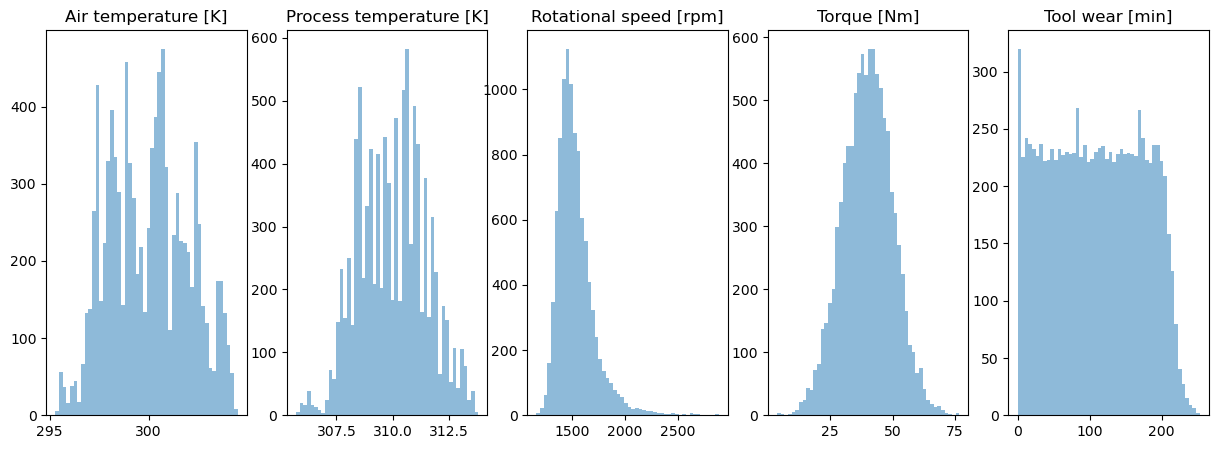

In [9]:
fig, axs = plt.subplots(1, 5, figsize=(15, 5))

# Plot data in each subplot
axs[0].hist(input_data['Air temperature [K]'], bins=50, alpha=0.5)
axs[0].set_title('Air temperature [K]')

axs[1].hist(input_data['Process temperature [K]'], bins=50, alpha=0.5)
axs[1].set_title('Process temperature [K]')

axs[2].hist(input_data['Rotational speed [rpm]'], bins=50, alpha=0.5)
axs[2].set_title('Rotational speed [rpm]')

axs[3].hist(input_data['Torque [Nm]'], bins=50, alpha=0.5)
axs[3].set_title('Torque [Nm]')

axs[4].hist(input_data['Tool wear [min]'], bins=50, alpha=0.5)
axs[4].set_title('Tool wear [min]')
plt.show()

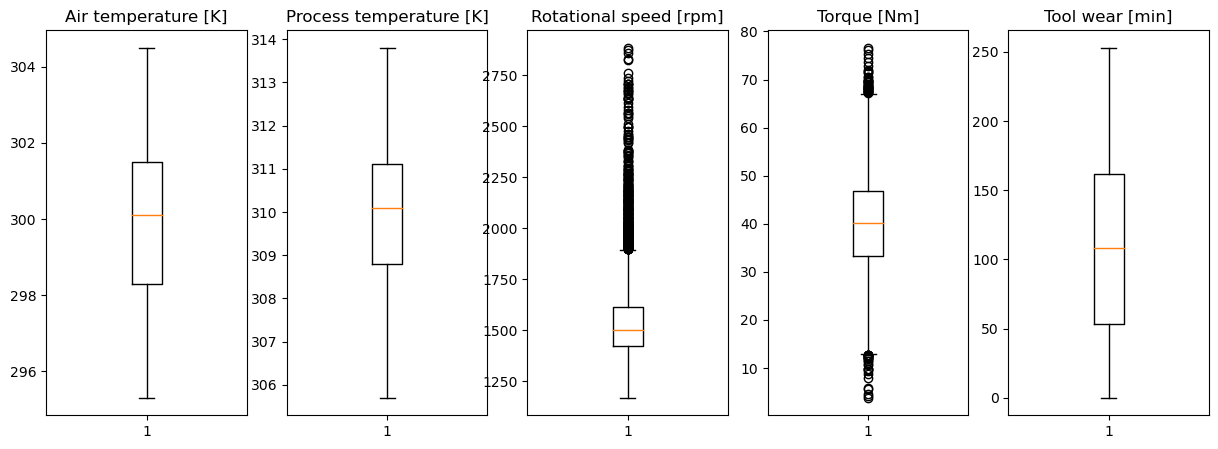

In [10]:
fig, axs = plt.subplots(1, 5, figsize=(15, 5))

# Plot data in each subplot
axs[0].boxplot(input_data['Air temperature [K]'])
axs[0].set_title('Air temperature [K]')

axs[1].boxplot(input_data['Process temperature [K]'])
axs[1].set_title('Process temperature [K]')

axs[2].boxplot(input_data['Rotational speed [rpm]'])
axs[2].set_title('Rotational speed [rpm]')

axs[3].boxplot(input_data['Torque [Nm]'])
axs[3].set_title('Torque [Nm]')

axs[4].boxplot(input_data['Tool wear [min]'])
axs[4].set_title('Tool wear [min]')
plt.show()

In [11]:
for col in input_data.columns:
    print(f'Unique values in {col} : {input_data[col].unique()}') 

Unique values in UDI : [    1     2     3 ...  9998  9999 10000]
Unique values in Product ID : ['M14860' 'L47181' 'L47182' ... 'M24857' 'H39412' 'M24859']
Unique values in Type : ['M' 'L' 'H']
Unique values in Air temperature [K] : [298.1 298.2 298.3 298.5 298.4 298.6 298.7 298.8 298.9 299.  299.1 298.
 297.9 297.8 297.7 297.6 297.5 297.4 297.3 297.2 297.1 297.  296.9 296.8
 296.7 296.6 296.5 296.3 296.4 296.2 296.1 296.  295.9 295.8 295.7 295.6
 295.5 295.4 295.3 299.2 299.3 299.5 299.4 299.6 299.7 299.8 299.9 300.
 300.1 300.2 300.3 300.4 300.5 300.6 300.7 300.8 300.9 301.  301.1 301.2
 301.3 301.4 301.5 301.6 301.7 301.8 301.9 302.  302.1 302.2 302.3 302.4
 302.5 302.6 302.7 302.8 302.9 303.  303.1 303.2 303.3 303.4 303.5 303.6
 303.7 303.8 303.9 304.  304.1 304.2 304.3 304.4 304.5]
Unique values in Process temperature [K] : [308.6 308.7 308.5 309.  308.9 309.1 309.2 309.3 309.4 309.5 308.8 308.4
 308.3 308.2 308.1 308.  307.9 309.6 309.7 309.8 309.9 310.  310.1 310.2
 307.8 307.7 3

In [12]:
input_data[input_data.RNF==1].shape

(19, 14)

### Result Note: There are 19 observations of random failure RNF that we have to drop because this is a random event.

We have to check for observations which have both RNF and other types of failure. 

In [13]:
input_data.columns[9:13]

Index(['TWF', 'HDF', 'PWF', 'OSF'], dtype='object')

In [14]:
for col in input_data.columns[9:13]:
    input_data['both_are_1']=(input_data[col] == 1) & (input_data['RNF'] == 1)
    print(input_data[input_data['both_are_1'] ==True])

       UDI Product ID Type  Air temperature [K]  Process temperature [K]  \
3611  3612     L50791    L                301.7                    310.9   

      Rotational speed [rpm]  Torque [Nm]  Tool wear [min]  Machine failure  \
3611                    1405         46.4              207                1   

      TWF  HDF  PWF  OSF  RNF  both_are_1  
3611    1    0    0    0    1        True  
Empty DataFrame
Columns: [UDI, Product ID, Type, Air temperature [K], Process temperature [K], Rotational speed [rpm], Torque [Nm], Tool wear [min], Machine failure, TWF, HDF, PWF, OSF, RNF, both_are_1]
Index: []
Empty DataFrame
Columns: [UDI, Product ID, Type, Air temperature [K], Process temperature [K], Rotational speed [rpm], Torque [Nm], Tool wear [min], Machine failure, TWF, HDF, PWF, OSF, RNF, both_are_1]
Index: []
Empty DataFrame
Columns: [UDI, Product ID, Type, Air temperature [K], Process temperature [K], Rotational speed [rpm], Torque [Nm], Tool wear [min], Machine failure, TWF, HDF

### Result Note: Observation with index 3611 have RNF and TWF failures.

<a name="4"></a>
# Data Cleaning
We want to drop all the observations with RNF=1 except the observation with index 3611

In [15]:
index_to_keep=3611

In [16]:
cleaned_data=input_data[(input_data['RNF']!=1) | (input_data.index==index_to_keep)]
cleaned_data.shape

(9982, 15)

In [17]:
cleaned_data.index

Index([   0,    1,    2,    3,    4,    5,    6,    7,    8,    9,
       ...
       9990, 9991, 9992, 9993, 9994, 9995, 9996, 9997, 9998, 9999],
      dtype='int64', length=9982)

In [18]:
# Reset the index
cleaned_data = cleaned_data.reset_index(drop=True)
cleaned_data.index

RangeIndex(start=0, stop=9982, step=1)

In [19]:
print(input_data.shape[0]-cleaned_data.shape[0]) # check how many observations we have dropped

18


In [20]:
cleaned_data.columns

Index(['UDI', 'Product ID', 'Type', 'Air temperature [K]',
       'Process temperature [K]', 'Rotational speed [rpm]', 'Torque [Nm]',
       'Tool wear [min]', 'Machine failure', 'TWF', 'HDF', 'PWF', 'OSF', 'RNF',
       'both_are_1'],
      dtype='object')

In [21]:
cleaned_data=cleaned_data.drop('both_are_1', axis=1) # drop the spare column.


<a name="5"></a>
# Assigning independent variables

In [22]:
x=cleaned_data.drop(['UDI', 'Product ID','Type','Machine failure', 'TWF', 'HDF', 'PWF', 'OSF', 'RNF'], axis=1)
# x.head()
# x.tail()
# x.shape
x.index

RangeIndex(start=0, stop=9982, step=1)

# Assigning dependent variable

In [23]:
y_uni=cleaned_data['Machine failure']
# y_uni.shape
y_uni.index

RangeIndex(start=0, stop=9982, step=1)

<a name="6"></a>
# Scaling independent varaibles

We need to scale the independent variables because they vary in large range.

In [24]:
std_scaler=StandardScaler()
x_scaled=std_scaler.fit_transform(x)

In [25]:
std_deviation=std_scaler.scale_
print(std_deviation)
means=std_scaler.mean_
print(means)

[  2.00040628   1.48336138 179.36613812   9.96621315  63.64346721]
[ 300.0035564   310.00420757 1538.8650571    39.98053496  107.92947305]


In [26]:
x_scaled

array([[-0.95158489, -0.94663889,  0.06765459,  0.28290234, -1.69584527],
       [-0.90159505, -0.87922444, -0.72959734,  0.63408889, -1.64870768],
       [-0.95158489, -1.01405335, -0.22783039,  0.94513983, -1.61728261],
       ...,
       [-0.50167629, -0.94663889,  0.5917223 , -0.66028439, -1.35016957],
       [-0.50167629, -0.87922444, -0.72959734,  0.85483472, -1.30303198],
       [-0.50167629, -0.87922444, -0.21668001,  0.02202091, -1.22446932]])

In [27]:
m_positive=cleaned_data[cleaned_data['Machine failure']==1].shape[0] # All positives in the cleaned dataset
m = cleaned_data.shape[0]
print(f'{(m_positive/m):.3f}')

0.034


### Result Note: We have only 3% positive values. The dataset is highly imbalanced. Accuracy will not be a good metrics for this classification problem.

<a name="7"></a>
# Splitting the dataset

In [28]:
X_train, X_test, y_uni_train, y_uni_test = train_test_split(x_scaled,y_uni,test_size=0.25, random_state=1, stratify=y_uni)

In [29]:
# Check the number of positive values in the sets
print(f"Number of Positives in the initial dataset: {y_uni.sum()}")
print(f"Number of Positives in the train set: {y_uni_train.sum()}")
print(f"Number of Positives in the test set: {y_uni_test.sum()}")

Number of Positives in the initial dataset: 339
Number of Positives in the train set: 254
Number of Positives in the test set: 85


### Result Note: The Positive values observations are proportionally distibuted after the dataset splitting.

<a name="8"></a>
# Binary Classification - Logistic regression

## Baseline establishment - no regularization

In [30]:
from sklearn.linear_model import LogisticRegression

lr_model = LogisticRegression(penalty=None, class_weight='balanced') # taking into account the imbalanced data

In [31]:
lr_model.fit(X_train, y_uni_train)

LogisticRegression(class_weight='balanced', penalty=None)

## Metrics

### Confusion matrix

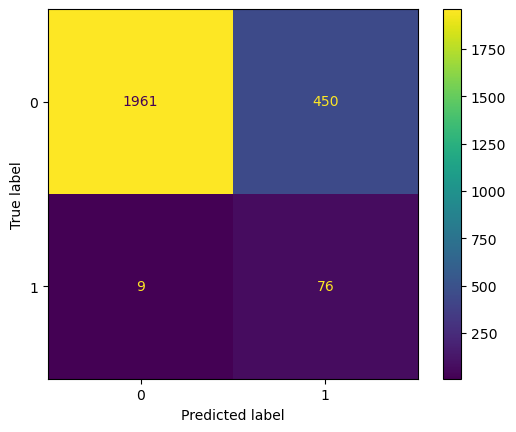

In [32]:
plot_conf_matrix(lr_model,X_test,y_uni_test)

### Classification metrics

In [33]:
y_uni_pred = lr_model.predict(X_train)
print(f"Accuracy on training set: {lr_model.score(X_train, y_uni_train):.3f}")
print(f"F1 score training set: {f1_score(y_uni_train, y_uni_pred, average = 'binary'):.3f}")

Accuracy on training set: 0.811
F1 score training set: 0.224


### Metrics on test set

In [34]:
print_classification_metrics(lr_model, X_test,y_uni_test)

Accuracy: 0.816
Precision: 0.144
Recall: 0.894
F1 score: 0.249
Fbeta score (beta=2): 0.439


### ROC curve

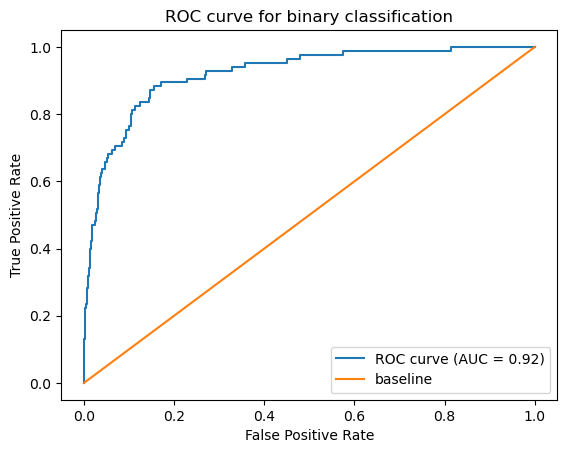

In [35]:
plot_ROC(lr_model, X_test,y_uni_test)

<a name="9"></a>
# Binary Classification - Gradient Boosting

In [36]:
from sklearn.ensemble import GradientBoostingClassifier

In [37]:
gb_model = GradientBoostingClassifier(n_estimators=300,learning_rate=0.05,random_state=1,max_features = 5)
gb_model.fit(X_train, y_uni_train)


GradientBoostingClassifier(learning_rate=0.05, max_features=5, n_estimators=300,
                           random_state=1)

## Metrics

### Confusion matrix

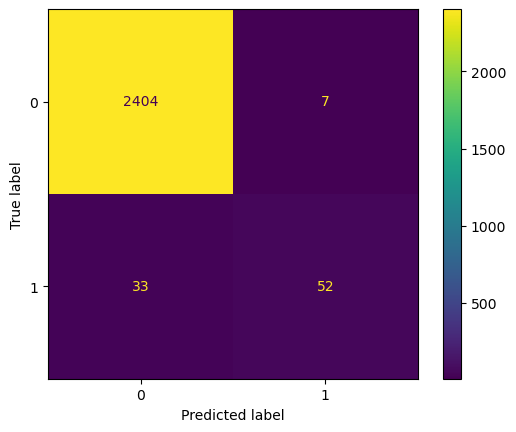

In [38]:
plot_conf_matrix(gb_model,X_test,y_uni_test)

### Classification metrics

In [39]:
y_uni_pred = gb_model.predict(X_train)
print(f"Accuracy on training set: {gb_model.score(X_train, y_uni_train):.3f}")
print(f"F1 score training set: {f1_score(y_uni_train, y_uni_pred, average = 'binary'):.3f}")

Accuracy on training set: 0.993
F1 score training set: 0.879


### Metrics on test set

In [40]:
print_classification_metrics(gb_model, X_test,y_uni_test)

Accuracy: 0.984
Precision: 0.881
Recall: 0.612
F1 score: 0.722
Fbeta score (beta=2): 0.652


### ROC curve

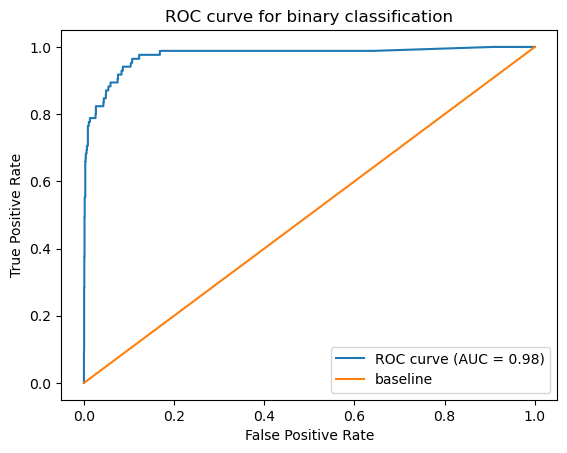

In [41]:
plot_ROC(gb_model,X_test,y_uni_test)

<a name="10"></a>
# Binary Classification - XGBoost

In [42]:
from xgboost import XGBClassifier


scale_pos_weight = sum(y_uni_train == 0) / sum(y_uni_train == 1)
# print(scale_pos_weight)
xgb_model = XGBClassifier(n_estimators = 500, learning_rate = 0.1,
                          verbosity = 1, random_state = 1, objective='binary:logistic', 
                          scale_pos_weight=sum(y_uni_train == 0) / sum(y_uni_train == 1),
                         )
xgb_model.fit(X_train,y_uni_train)

C:\Users\mbotev\.conda\envs\paper\Lib\site-packages\xgboost\data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=500, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=1, ...)

## Metrcis

### Confusion matrix

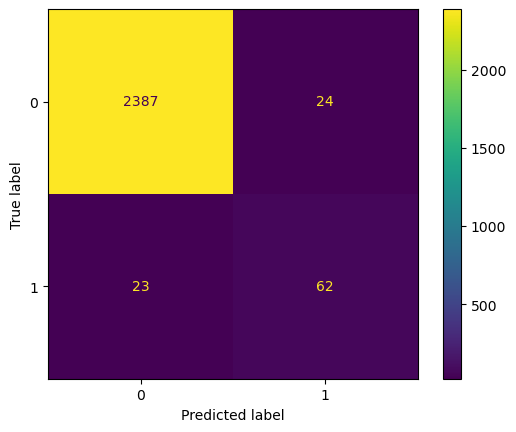

In [43]:
plot_conf_matrix(xgb_model,X_test,y_uni_test)

### Classification metrics

In [44]:
y_uni_pred = xgb_model.predict(X_train)
print(f"Accuracy on training set: {xgb_model.score(X_train, y_uni_train):.3f}")
print(f"F1 score training set: {f1_score(y_uni_train, y_uni_pred, average = 'binary'):.3f}")

Accuracy on training set: 1.000
F1 score training set: 1.000


### Metrics on test set

In [45]:
print_classification_metrics(xgb_model, X_test,y_uni_test)

Accuracy: 0.981
Precision: 0.721
Recall: 0.729
F1 score: 0.725
Fbeta score (beta=2): 0.728


### ROC curve

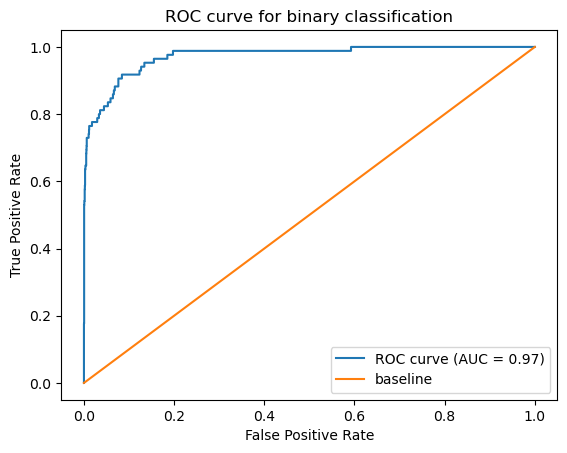

In [46]:
plot_ROC(xgb_model, X_test,y_uni_test)

### Feature importances

#### We need to check the importance of every feature

In [47]:
print(f"List of features: {x.info()}")

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9982 entries, 0 to 9981
Data columns (total 5 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Air temperature [K]      9982 non-null   float64
 1   Process temperature [K]  9982 non-null   float64
 2   Rotational speed [rpm]   9982 non-null   int64  
 3   Torque [Nm]              9982 non-null   float64
 4   Tool wear [min]          9982 non-null   int64  
dtypes: float64(3), int64(2)
memory usage: 390.1 KB
List of features: None


In [48]:
xgb_model.feature_importances_

array([0.08101881, 0.06237318, 0.34202683, 0.25595602, 0.25862518],
      dtype=float32)

In [49]:
from sklearn.inspection import permutation_importance

per_im=permutation_importance(xgb_model, X_train, y_uni_train, n_repeats=5) 
print(f"Mean: {per_im['importances_mean']}")
print(f" Std: {per_im['importances_std']}")

Mean: [0.03382314 0.02046487 0.03083088 0.04162437 0.023751  ]
 Std: [0.00094985 0.00055658 0.00119301 0.00045182 0.00137376]


### Result Note: No need of features selection. All feature have almost the same importance.

<a name="11"></a>
# Comparison of all models

## Confusion matrix

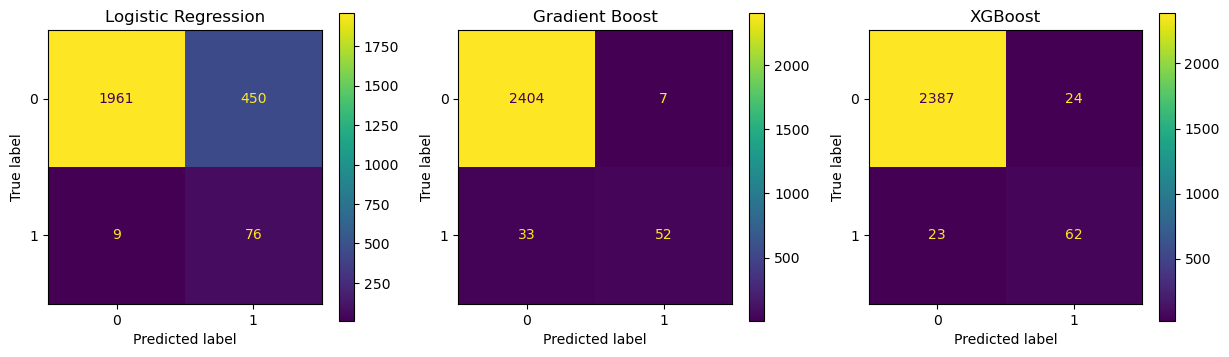

In [50]:
fig, axs = plt.subplots(1, 3, figsize=(15, 4))

plot_conf_matrix(lr_model,X_test,y_uni_test, 0)
plot_conf_matrix(gb_model,X_test,y_uni_test, 1)
plot_conf_matrix(xgb_model,X_test,y_uni_test, 2)
axs[0].set_title('Logistic Regression')
axs[1].set_title('Gradient Boost')
axs[2].set_title('XGBoost')

# Display the figure with the subplots
plt.show()

## ROC curve

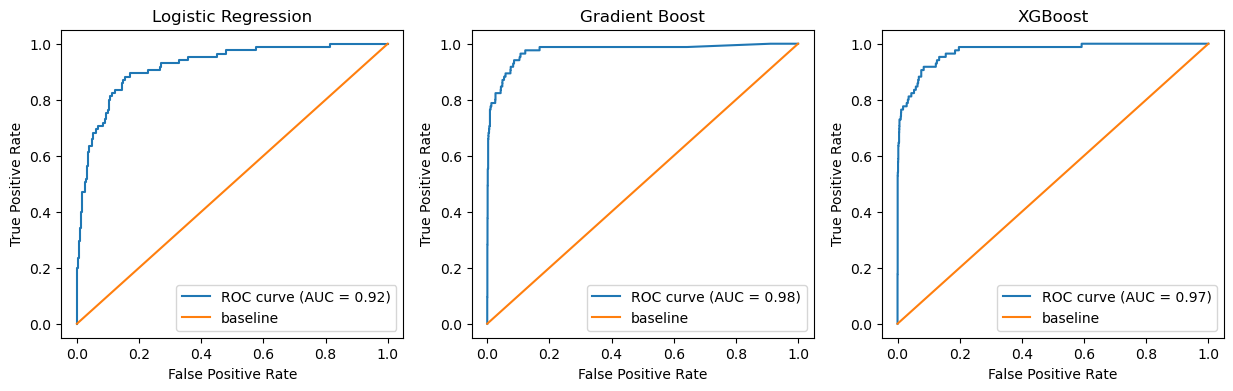

In [51]:
fig, axs = plt.subplots(1, 3, figsize=(15, 4))

plot_ROC(lr_model,X_test,y_uni_test,0)
axs[0].set_title('Logistic Regression')
plot_ROC(gb_model, X_test,y_uni_test,1)
axs[1].set_title('Gradient Boost')
plot_ROC(xgb_model, X_test,y_uni_test,2)
axs[2].set_title('XGBoost')

# Display the figure with the subplots
plt.show()

## Classification metrics

### Metrics on train set

In [52]:
total_metrics = pd.DataFrame({
    'Logistic Regression': print_classification_metrics(lr_model, X_train, y_uni_train, 'tuple'),
    'Gradient Boost': print_classification_metrics(gb_model, X_train, y_uni_train, 'tuple'),
    'XGBoost': print_classification_metrics(xgb_model, X_train, y_uni_train, 'tuple')
}, index=['Accuracy score', 'Precision', 'Recall', 'F1 score', 'Fbeta score (beta=2)'])
print(total_metrics.to_markdown())

|                      |   Logistic Regression |   Gradient Boost |   XGBoost |
|:---------------------|----------------------:|-----------------:|----------:|
| Accuracy score       |              0.81098  |         0.992519 |         1 |
| Precision            |              0.130019 |         0.975962 |         1 |
| Recall               |              0.80315  |         0.799213 |         1 |
| F1 score             |              0.223807 |         0.878788 |         1 |
| Fbeta score (beta=2) |              0.394584 |         0.829248 |         1 |


### Metrics on test set

In [53]:
total_metrics = pd.DataFrame({
    'Logistic Regression': print_classification_metrics(lr_model, X_test,y_uni_test, 'tuple'),
    'Gradient Boost': print_classification_metrics(gb_model, X_test,y_uni_test, 'tuple'),
    'XGBoost': print_classification_metrics(xgb_model, X_test,y_uni_test, 'tuple')
}, index=['Accuracy score', 'Precision', 'Recall', 'F1 score', 'Fbeta score (beta=2)'])
print(total_metrics.to_markdown())

|                      |   Logistic Regression |   Gradient Boost |   XGBoost |
|:---------------------|----------------------:|-----------------:|----------:|
| Accuracy score       |              0.816106 |         0.983974 |  0.98117  |
| Precision            |              0.144487 |         0.881356 |  0.72093  |
| Recall               |              0.894118 |         0.611765 |  0.729412 |
| F1 score             |              0.248773 |         0.722222 |  0.725146 |
| Fbeta score (beta=2) |              0.438799 |         0.651629 |  0.7277   |


### Result Note: With this dataset, trained by XGBoost model we can obtain low bias but high variance . The model overfits. We decide to perform a Regularization of the model and Tunning of hyperparameters.

<a name="12"></a>
# Tunning the best model

### Regularization of XGBoost

C:\Users\mbotev\.conda\envs\paper\Lib\site-packages\xgboost\data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Accuracy: 0.971
Precision: 0.550
Recall: 0.847
F1 score: 0.667
Fbeta score (beta=2): 0.764


C:\Users\mbotev\.conda\envs\paper\Lib\site-packages\_distutils_hack\__init__.py:33: UserWarning: Setuptools is replacing distutils.
  warnings.warn("Setuptools is replacing distutils.")


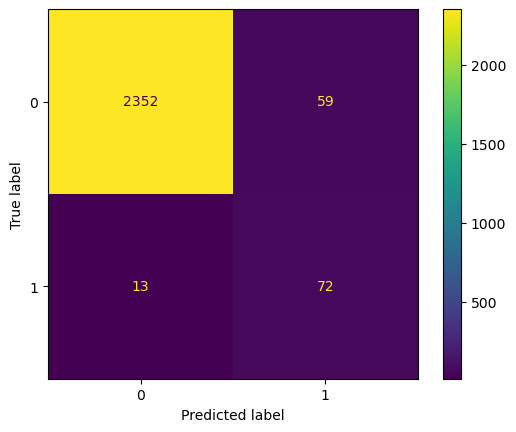

In [54]:
# defining a new experiment
experiment_name = 'XGBoostClassification'
# returns experiment ID
try:
    # creating a new experiment
    exp_id = mlflow.create_experiment(name=experiment_name)
except Exception as e:
    exp_id = mlflow.get_experiment_by_name(experiment_name).experiment_id


if 'xgb_model_tunning' not in os.listdir():
    os.mkdir('xgb_model_tunning')
    
# starting an mlflow run, and tracking them under the experiment defined above
with mlflow.start_run(experiment_id=exp_id, run_name='XGBoostClassification'):
    
    # adding tags to the run
    mlflow.set_tag('Description','XGBoostClassification')
    mlflow.set_tags({'ProblemType': 'Classification', 'ModelType': 'XGBoostClassification', 'ModelLibrary': 'sklearn'})
    
    # Training, and test set preparation
    X_train, X_test, y_uni_train, y_uni_test = train_test_split(x_scaled,y_uni,test_size=0.25, random_state=1, stratify=y_uni) # taking into account the inbalanced dataset
    
    
    # logging artifacts -> saves the copy of the data and enables tracking for later use
    mlflow.log_artifacts('xgb_model_tunning')
    
    
    #hyperparameters
    lambda_=200
    alpha_=0
    gamma_=0
    
    
    scale_pos_weight = sum(y_uni_train == 0) / sum(y_uni_train == 1)
    # print(scale_pos_weight)
    xgb_model = XGBClassifier(n_estimators = 500, learning_rate = 0.1,
                          verbosity = 1, random_state = 1, objective='binary:logistic', 
                          scale_pos_weight=sum(y_uni_train == 0) / sum(y_uni_train == 1),
                          reg_lambda=lambda_,
                          reg_alpha=alpha_,
                          gamma=gamma_)
    
    #Learning fit(X,y)
    xgb_model.fit(X_train,y_uni_train)

    
    # logging explaination of the model
    # mlflow.shap.log_explanation(xbg_model.predict_proba, X_train)
    
    # making predictions on train set
   # y_uni_pred_train = xgb_model.predict(X_train)
    
    
    # making predictions on test set
    y_uni_pred = xgb_model.predict(X_test)
    
    # obtaining the model performance
    ac=accuracy_score(y_uni_test, y_uni_pred)
    pr=precision_score(y_uni_test, y_uni_pred, average = 'binary')
    rc=recall_score(y_uni_test, y_uni_pred, average = 'binary')
    f1=f1_score(y_uni_test, y_uni_pred, average = 'binary')
    f_beta=fbeta_score(y_uni_test, y_uni_pred, beta=2, average = 'binary')
    
    # print the metrics
    print(f'Accuracy: {ac:.3f}')
    print(f"Precision: {pr:.3f}")
    print(f"Recall: {rc:.3f}")
    print(f"F1 score: {f1:.3f}")
    print(f"Fbeta score (beta=2): {f_beta:.3f}")
    
    # logging hyperparameters defined above
    mlflow.log_param("lamnda L2", lambda_)
    mlflow.log_param("alpha L1", alpha_)
    mlflow.log_param("gamma", gamma_)
    
    # logging performance of the model
    mlflow.log_metric("accuracy", ac)
    mlflow.log_metric("precision", pr)
    mlflow.log_metric("recall", rc)
    mlflow.log_metric("f1 score", f1)
    mlflow.log_metric("f_beta", f_beta)
    
    
    # Plot Confusion matrix 
    plot_conf_matrix(xgb_model,X_test,y_uni_test)
    
    mlflow.sklearn.log_model(xgb_model, 'XGBoostClassification')

#### MLflow server URL

In [55]:
# mlflow tracking user interface
print("MLflow Version:", mlflow.version.VERSION)
mlflow.set_tracking_uri("http://localhost:5000")
print("Tracking URI:", mlflow.tracking.get_tracking_uri())

MLflow Version: 2.6.0
Tracking URI: http://localhost:5000


### Result Note: The best result of  F1= 0.667 and Fbeta = 0.764 is obtained with Lambda=200

In [56]:

xgb_model_reg = XGBClassifier(n_estimators = 500, learning_rate = 0.1,
                          verbosity = 1, random_state = 1, objective='binary:logistic', 
                          scale_pos_weight=sum(y_uni_train == 0) / sum(y_uni_train == 1),
                          reg_lambda=200)

xgb_model_reg.fit(X_train, y_uni_train)

C:\Users\mbotev\.conda\envs\paper\Lib\site-packages\xgboost\data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=500, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=1, ...)

### Metrics on train set

In [57]:
print_classification_metrics(xgb_model_reg, X_train,y_uni_train)

Accuracy: 0.981
Precision: 0.645
Recall: 1.000
F1 score: 0.784
Fbeta score (beta=2): 0.901


### Metrics on test set

In [58]:
print_classification_metrics(xgb_model_reg, X_test,y_uni_test)

Accuracy: 0.971
Precision: 0.550
Recall: 0.847
F1 score: 0.667
Fbeta score (beta=2): 0.764


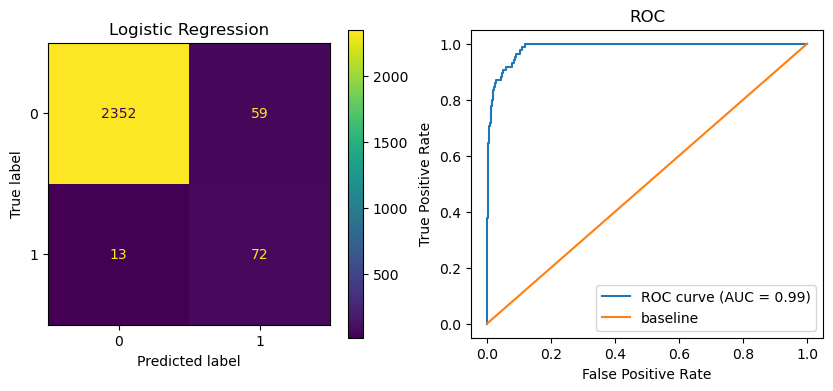

In [59]:
fig, axs = plt.subplots(1, 2, figsize=(10, 4))

plot_conf_matrix(xgb_model_reg,X_test,y_uni_test,0)
axs[0].set_title('Logistic Regression')
plot_ROC(xgb_model_reg, X_test,y_uni_test,1)
axs[1].set_title('ROC')

# Display the figure with the subplots
plt.show()

### Result Note: We will perform also tunning of several XGB parameters.

### Tunning XGB classifier

In [60]:

param_grid = {
    'max_depth': [3, 5, 7, 10, 20, None],
    'learning_rate': [0.1, 0.01, 0.001],
    'subsample': [0.5, 0.7, 1]
}

stratified_kfold = StratifiedKFold(n_splits=3, shuffle=True, random_state=1)

# Create the GridSearchCV object
grid_search = GridSearchCV(xgb_model_reg, param_grid, cv=stratified_kfold, scoring='f1')

# Fit the GridSearchCV object to the training data
grid_search.fit(X_train, y_uni_train)

C:\Users\mbotev\.conda\envs\paper\Lib\site-packages\xgboost\data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
C:\Users\mbotev\.conda\envs\paper\Lib\site-packages\xgboost\data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
C:\Users\mbotev\.conda\envs\paper\Lib\site-packages\xgboost\data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
C:\Users\mbotev\.conda\envs\paper\Lib\site-packages\xgboost\data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
C:\Users\mbotev\.conda\envs\paper\Lib\site-packages\xgboost\data.py:440: FutureWarning: is_spars

GridSearchCV(cv=StratifiedKFold(n_splits=3, random_state=1, shuffle=True),
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, gamma=None,
                                     gpu_id=None, grow_policy=None,
                                     importance_type...
                                     max_cat_threshold=None,
                                     max_cat_to_onehot=None,
                                     max_delta_step=None, max_depth=None,
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     n_estimators=500, n_jobs=None,
                                     num_parallel_tree=None, predictor=None,
                                     random_state=1, ...),
             param_grid={'learning_rate': [0.1, 0.01, 0.001],
                         'max_depth': [3, 5, 7, 10, 20, None],
                         'subsample': [0.5, 0.7, 1]},
             scoring='f1')

#### The optimal hyperparameters are:

In [61]:
#grid_search.cv_results_
print(f"The optimal parameters of XGBoost model: {grid_search.best_params_}")
# grid_search.best_score_

The optimal parameters of XGBoost model: {'learning_rate': 0.1, 'max_depth': 10, 'subsample': 1}


### Metrics on train set

In [62]:
print_classification_metrics(grid_search, X_train,y_uni_train)

Accuracy: 0.988
Precision: 0.736
Recall: 1.000
F1 score: 0.848
Fbeta score (beta=2): 0.933


### Metrics on test set

In [63]:
print_classification_metrics(grid_search, X_test,y_uni_test)

Accuracy: 0.977
Precision: 0.630
Recall: 0.800
F1 score: 0.705
Fbeta score (beta=2): 0.759


<a name="16"></a>
### The best possible XGB Model on this dataset

In [64]:
xgb_model_reg_tunned = XGBClassifier(n_estimators = 500, max_depth=10, learning_rate = 0.1,
                          verbosity = 1, random_state = 1, objective='binary:logistic', 
                          scale_pos_weight=sum(y_uni_train == 0) / sum(y_uni_train == 1),
                          reg_lambda=200)
xgb_model_reg_tunned.fit(X_train, y_uni_train)

C:\Users\mbotev\.conda\envs\paper\Lib\site-packages\xgboost\data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=10, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=500, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=1, ...)

### Metrics on test set

In [65]:
print_classification_metrics(xgb_model_reg_tunned, X_test,y_uni_test)

Accuracy: 0.977
Precision: 0.630
Recall: 0.800
F1 score: 0.705
Fbeta score (beta=2): 0.759


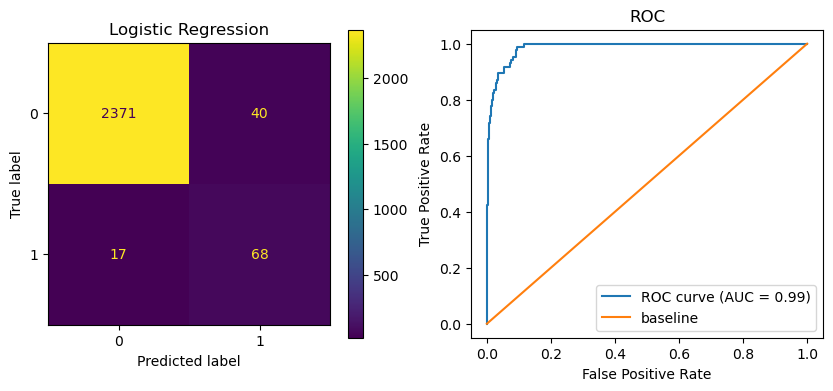

In [66]:
fig, axs = plt.subplots(1, 2, figsize=(10, 4))

plot_conf_matrix(xgb_model_reg_tunned,X_test,y_uni_test,0)
axs[0].set_title('Logistic Regression')
plot_ROC(xgb_model_reg_tunned, X_test,y_uni_test,1)
axs[1].set_title('ROC')

# Display the figure with the subplots
plt.show()

<a name="13"></a>
# Comparative approaches

## Logistic Regression tunning with Polynominal Features

In [67]:

lr_model = LogisticRegression(penalty=None, class_weight='balanced', solver='saga', max_iter=10)
poly = PolynomialFeatures(degree=2)
# constructing pipeline
lr_pipeline = Pipeline([('poly', poly), ('lr', lr_model)])
# fit model
lr_pipeline.fit(X_train, y_uni_train)


C:\Users\mbotev\.conda\envs\paper\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


Pipeline(steps=[('poly', PolynomialFeatures()),
                ('lr',
                 LogisticRegression(class_weight='balanced', max_iter=10,
                                    penalty=None, solver='saga'))])

### Metrics on test set

In [68]:
print_classification_metrics(lr_pipeline, X_test,y_uni_test)

Accuracy: 0.871
Precision: 0.197
Recall: 0.906
F1 score: 0.324
Fbeta score (beta=2): 0.527


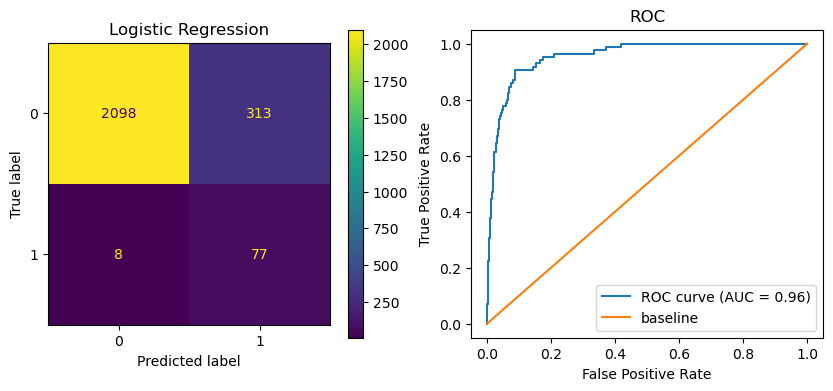

In [69]:
fig, axs = plt.subplots(1, 2, figsize=(10, 4))

plot_conf_matrix(lr_pipeline,X_test,y_uni_test,0)
axs[0].set_title('Logistic Regression')
plot_ROC(lr_pipeline, X_test,y_uni_test,1)
axs[1].set_title('ROC')

# Display the figure with the subplots
plt.show()

### Result Note: The Logistic Regression with degree 2 of Polynominal can not converge in 1e5 iterations, takes too long. We decide to abandon this approach.

## SVM model

In [70]:
from sklearn.svm import SVC
svm_model=SVC(C=1e10, kernel='rbf', gamma='auto', random_state=1, probability=True)

svm_model.fit(X_train, y_uni_train)

SVC(C=10000000000.0, gamma='auto', probability=True, random_state=1)

### Metrics on test set

In [71]:
print_classification_metrics(svm_model, X_test,y_uni_test)

Accuracy: 0.969
Precision: 0.533
Recall: 0.659
F1 score: 0.589
Fbeta score (beta=2): 0.629


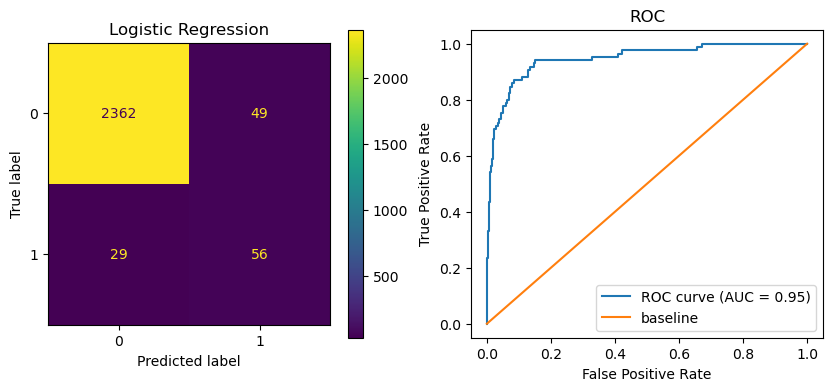

In [72]:
fig, axs = plt.subplots(1, 2, figsize=(10, 4))

plot_conf_matrix(svm_model,X_test,y_uni_test,0)
axs[0].set_title('Logistic Regression')
plot_ROC(svm_model, X_test,y_uni_test,1)
axs[1].set_title('ROC')

# Display the figure with the subplots
plt.show()

### Result Note: SVC(kernel=poly, degree=1) F1=0 (TP=0), takes too long; SVC(C=inf, kernel=rbf, gamma=auto) F1=0.57. This is a model without capacity on this dataset.

<a name="14"></a>
# Conclusion

### We have found out that the [regularized tunned XGBoost model](#16) has a relatively good capacity to predict but it is far from the industry requirements of 90% Fbeta(beta=2). Nevertheless, it could be used for early warning.

--------------------------------------------------------------------------------------------------------------------------------------------------

# For Future Research and Debug Purposes. For Getting Intuition. And Fun!

## Custom Binary Classification   /!\ This section is under development /!\

### Code

In [73]:
def sigmoid(z):
    """
    Compute the sigmoid of z

    Args:
        z (ndarray): A scalar, numpy array of any size.

    Returns:
        g (ndarray): sigmoid(z), with the same shape as z
         
    """
    g=1/(1+np.exp(-z))
    return g

def compute_cost_reg(X, y, w, b, lambda_ = 1):
    """
    Computes the cost over all examples
    Args:
      X : (ndarray Shape (m,n)) data, m examples by n features
      y : (ndarray Shape (m,))  target value 
      w : (ndarray Shape (n,))  values of parameters of the model      
      b : (scalar)              value of bias parameter of the model
      lambda_ : (scalar, float) Controls amount of regularization
    Returns:
      total_cost : (scalar)     cost 
    """
    
    m, n = X.shape
    total_loss=0
    for i in range(m):
        z_wb_i=np.dot(w,X[i])+b
        f_wb_i=sigmoid(z_wb_i)
        loss_i=(-y[i]*np.log(f_wb_i))-(1-y[i])*np.log(1-f_wb_i)
        total_loss+=loss_i
    total_cost=total_loss/m
    cost_without_reg = total_cost 

    reg_cost = 0.

    for j in range(n):
        reg_cost=reg_cost+w[j]**2

    reg_cost=(lambda_)*reg_cost/(2*m)
    total_cost = cost_without_reg + reg_cost

    return total_cost


def compute_gradient_reg(X, y, w, b, lambda_ = 1): 
    """
    Computes the gradient for logistic regression with regularization
 
    Args:
      X : (ndarray Shape (m,n)) data, m examples by n features
      y : (ndarray Shape (m,))  target value 
      w : (ndarray Shape (n,))  values of parameters of the model      
      b : (scalar)              value of bias parameter of the model
      lambda_ : (scalar,float)  regularization constant
    Returns
      dj_db : (scalar)             The gradient of the cost w.r.t. the parameter b. 
      dj_dw : (ndarray Shape (n,)) The gradient of the cost w.r.t. the parameters w. 

    """
    m, n = X.shape
    dj_dw = np.zeros(w.shape)
    dj_db = 0.

    for i in range(m):
        z_wb_i=np.dot(X[i],w)+b
        f_wb_i=sigmoid(z_wb_i)
        err_i=f_wb_i-y[i]
        z_wb = None
        for j in range(n):
            dj_dw[j]=dj_dw[j]+err_i*X[i,j]
            
        f_wb = None
        dj_db_i = None
        dj_db += err_i

    dj_dw = dj_dw/m
    dj_db = dj_db/m

        
    for j in range(n):
        dj_dw[j]+=(lambda_)*w[j]/m
        
    return dj_db, dj_dw

def gradient_descent(X, y, w_in, b_in, cost_function, gradient_function, alpha, num_iters, lambda_): 
    """
    Performs batch gradient descent to learn theta. Updates theta by taking 
    num_iters gradient steps with learning rate alpha
    
    Args:
      X :    (ndarray Shape (m, n) data, m examples by n features
      y :    (ndarray Shape (m,))  target value 
      w_in : (ndarray Shape (n,))  Initial values of parameters of the model
      b_in : (scalar)              Initial value of parameter of the model
      cost_function :              function to compute cost
      gradient_function :          function to compute gradient
      alpha : (float)              Learning rate
      num_iters : (int)            number of iterations to run gradient descent
      lambda_ : (scalar, float)    regularization constant
      
    Returns:
      w : (ndarray Shape (n,)) Updated values of parameters of the model after
          running gradient descent
      b : (scalar)                Updated value of parameter of the model after
          running gradient descent
    """
    
    # number of training examples
    m = len(X)
    
    # An array to store cost J and w's at each iteration primarily for graphing later
    J_history = []
    w_history = []
    
    for i in range(num_iters):

        # Calculate the gradient and update the parameters
        dj_db, dj_dw = gradient_function(X, y, w_in, b_in, lambda_)   

        # Update Parameters using w, b, alpha and gradient
        w_in = w_in - alpha * dj_dw               
        b_in = b_in - alpha * dj_db              
       
        # Save cost J at each iteration
        if i<100000:      # prevent resource exhaustion 
            cost =  cost_function(X, y, w_in, b_in, lambda_)
            J_history.append(cost)

        # Print cost every at intervals 10 times or as many iterations if < 10
        if i% math.ceil(num_iters/10) == 0 or i == (num_iters-1):
            w_history.append(w_in)
            print(f"Iteration {i:4}: Cost {float(J_history[-1]):8.2f}   ")
        
    return w_in, b_in, J_history, w_history #return w and J,w history for graphing


# .predict(X,y)

def predict(X, w, b): 
    """
    Predict whether the label is 0 or 1 using learned logistic
    regression parameters w
    
    Args:
      X : (ndarray Shape (m,n)) data, m examples by n features
      w : (ndarray Shape (n,))  values of parameters of the model      
      b : (scalar)              value of bias parameter of the model

    Returns:
      p : (ndarray (m,)) The predictions for X using a threshold at 0.5
    """
    m, n = X.shape   
    p = np.zeros(m)
   
    # Loop over each example
    for i in range(m):   
        z_wb = np.dot(X[i],w)+b
        f_wb=sigmoid(z_wb)
        
        p[i] = 1 if f_wb >=0.5 else 0
   
    return p





## Model training

In [74]:

# Training, dev and test set preparation
X_train, X_, y_uni_train, y_ = train_test_split(x_scaled,y_uni,test_size=0.40, random_state=1, stratify=y_uni)
X_cv, X_test, y_uni_cv, y_uni_test = train_test_split(X_,y_,test_size=0.50, random_state=1, stratify=y_)
# Reset the index

# Create a PolynomialFeatures object with the degree of the polynomial you want
poly = PolynomialFeatures(degree=1)

# Transform the data
X_train_poly = poly.fit_transform(X_train)

y_uni_train=y_uni_train.reset_index(drop=True)
y_uni_cv=y_uni_cv.reset_index(drop=True)
y_uni_test=y_uni_test.reset_index(drop=True)

#Learning fit(X,y)
# defining the initial parameters
np.random.seed(1)
initial_w = 0.01 * (np.random.rand(X_train_poly.shape[1]) - 0.5)
initial_b = -8

# Some gradient descent settings
iterations = 100
alpha = 5
lambda_=1


w,b, J_history, w_history = gradient_descent(X_train_poly, y_uni_train, initial_w, initial_b, compute_cost_reg, compute_gradient_reg, alpha, iterations, lambda_)

Iteration    0: Cost     0.25   
Iteration   10: Cost     0.12   
Iteration   20: Cost     0.11   
Iteration   30: Cost     0.11   
Iteration   40: Cost     0.10   
Iteration   50: Cost     0.10   
Iteration   60: Cost     0.10   
Iteration   70: Cost     0.10   
Iteration   80: Cost     0.10   
Iteration   90: Cost     0.10   
Iteration   99: Cost     0.10   


In [75]:
#Compute accuracy on our training set , for information
y_pred = predict(X_train_poly, w,b)
print(f'Train Accuracy: {np.mean(y_pred == y_uni_train):.3f}')

Train Accuracy: 0.970


In [76]:
X_cv_poly = poly.fit_transform(X_cv)

y_pred = predict(X_cv_poly, w,b)
ac=accuracy_score(y_uni_cv, y_pred)
pr=precision_score(y_uni_cv, y_pred, average = 'binary')
rc=recall_score(y_uni_cv, y_pred, average = 'binary')
f1=f1_score(y_uni_cv, y_pred, average = 'binary')
f_beta=fbeta_score(y_uni_cv, y_pred, beta=2, average = 'binary')
    
print(f'Accuracy: {ac:.3f}')
print(f"Precision: {pr:.3f}")
print(f"Recall: {rc:.3f}")
print(f"F1 score: {f1:.3f}")
print(f"Fbeta score (beta=2): {f_beta:.3f}")
print(J_history)
print(w_history)

Accuracy: 0.968
Precision: 0.778
Recall: 0.103
F1 score: 0.182
Fbeta score (beta=2): 0.125
[0.2496430459024605, 0.22781531210182798, 0.20641366480099765, 0.18582120473487035, 0.1667880519372357, 0.15059050154738302, 0.13869636860621296, 0.13151550679382942, 0.1277146562495719, 0.125510564366263, 0.12388181719341694, 0.12246934460204509, 0.12117239219289182, 0.11996013733588656, 0.1188189705694114, 0.11774039672020331, 0.11671818872913013, 0.11574750367432667, 0.11482446566395807, 0.11394590638559407, 0.11310918682833282, 0.1123120719371934, 0.1115526424158308, 0.11082923279491304, 0.110140387712369, 0.10948483027673137, 0.10886143774569748, 0.10826922073233347, 0.10770730291107415, 0.10717489889418538, 0.10667128873787772, 0.10619578853030871, 0.10574771774120126, 0.10532636536719486, 0.10493095811836604, 0.10456063457575682, 0.10421442905255345, 0.10389126768314924, 0.10358997727799107, 0.10330930527825997, 0.10304794738605837, 0.10280457860594205, 0.10257788361356485, 0.1023665833167

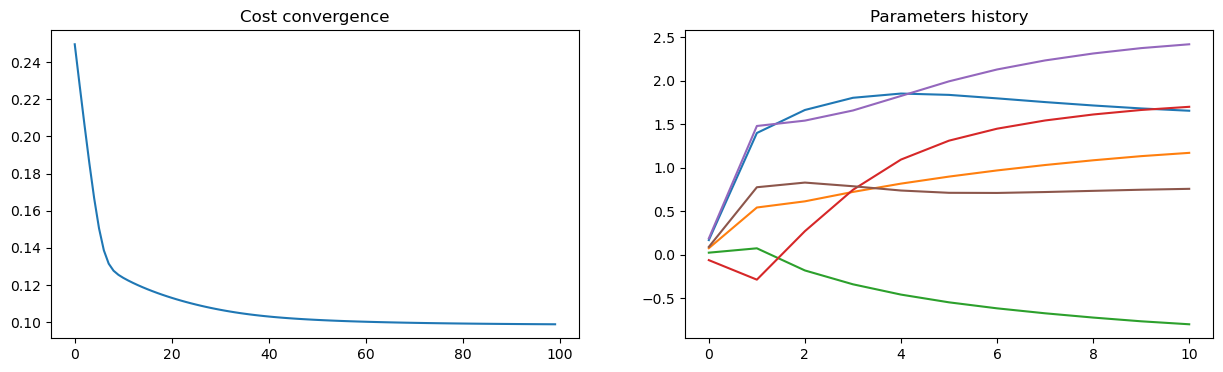

In [77]:
# Plot Cost convergence
fig, axs = plt.subplots(1, 2, figsize=(15, 4))

axs[0].plot(J_history)
axs[0].set_title('Cost convergence')
axs[1].plot(w_history)
axs[1].set_title('Parameters history')

plt.show()

## Model tunning with mlflow

Iteration    0: Cost     0.26   
Iteration   10: Cost     0.14   
Iteration   20: Cost     0.12   
Iteration   30: Cost     0.11   
Iteration   40: Cost     0.11   
Iteration   50: Cost     0.10   
Iteration   60: Cost     0.10   
Iteration   70: Cost     0.10   
Iteration   80: Cost     0.10   
Iteration   90: Cost     0.10   
Iteration   99: Cost     0.10   
Accuracy: 0.968
Precision: 0.778
Recall: 0.103
F1 score: 0.182
Fbeta score (beta=2): 0.125


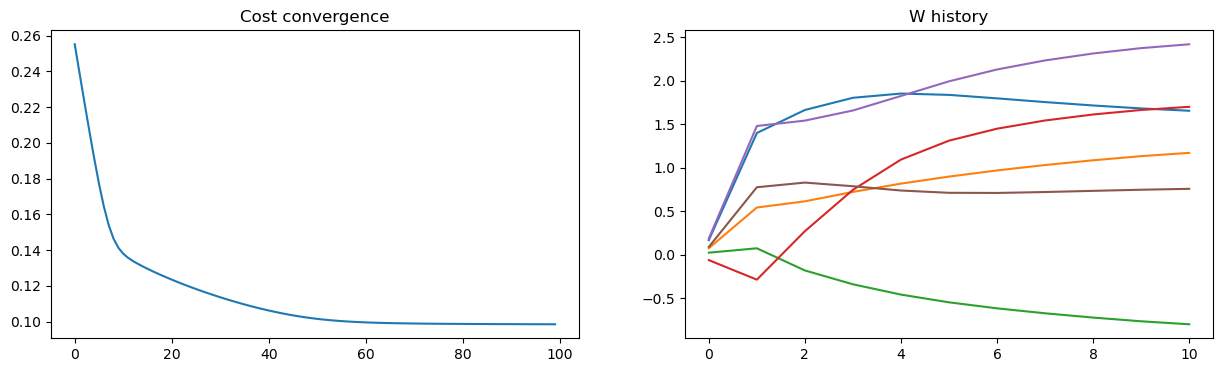

In [78]:
# defining a new experiment
experiment_name = 'SimpleCustomClassification'
# returns experiment ID
try:
    # creating a new experiment
    exp_id = mlflow.create_experiment(name=experiment_name)
except Exception as e:
    exp_id = mlflow.get_experiment_by_name(experiment_name).experiment_id


if 'model_tunning' not in os.listdir():
    os.mkdir('model_tunning')
    
# starting an mlflow run, and tracking them under the experiment defined above
with mlflow.start_run(experiment_id=exp_id, run_name='Custom_Classification_Model'):
    
    # adding tags to the run
    mlflow.set_tag('Description','Custom Classification Model')
    mlflow.set_tags({'ProblemType': 'Classification', 'ModelType': 'Logistic Regression', 'ModelLibrary': 'Custom'})
    
    # Training, dev and test set preparation
    X_train, X_, y_uni_train, y_ = train_test_split(x_scaled,y_uni,test_size=0.40, random_state=1, stratify=y_uni) # taking into account the inbalanced dataset
    X_cv, X_test, y_uni_cv, y_uni_test = train_test_split(X_,y_,test_size=0.50, random_state=1, stratify=y_)
    # Reset the index

    y_uni_train=y_uni_train.reset_index(drop=True)
    y_uni_cv=y_uni_cv.reset_index(drop=True)
    y_uni_test=y_uni_test.reset_index(drop=True)
    
    y_uni_train.to_csv('model_tunning/y_uni_train.csv', sep=',', index=False)
    y_uni_cv.to_csv('model_tunning/y_uni_cv.csv', sep=',', index=False)
    y_uni_test.to_csv('model_tunning/y_uni_test.csv', sep=',', index=False)
    
    # logging artifacts -> saves the copy of the data and enables tracking for later use
    mlflow.log_artifacts('model_tunning')
    
    # define a custom model -FOR FUTURE IMPLEMENTATION
    class MyModel(mlflow.pyfunc.PythonModel):
        def predict(self, context, model_input, params=None):
            return self.my_custom_function(model_input, params)

        def my_custom_function(self, model_input, params=None):
            # do something with the model input
            return 0
        
    #Learning fit(X,y)
    # defining the initial parameters
    np.random.seed(1)
    initial_w = 0.01 * (np.random.rand(X_train.shape[1]) - 0.5)
    initial_b = -8

    # Some gradient descent settings
    iterations = 100
    alpha = 5
    lambda_=1
    
    model = gradient_descent(X_train, y_uni_train, initial_w, initial_b, compute_cost_reg, compute_gradient_reg, alpha, iterations, lambda_)
    w,b, J_history,_ = model
    
    # logging explaination of the model
    # mlflow.shap.log_explanation(model.predict_proba, X_train)
    
    # making predictions on dev set
    y_pred = predict(X_cv, w,b)
    
    # obtaining the model performance
    ac=accuracy_score(y_uni_cv, y_pred)
    pr=precision_score(y_uni_cv, y_pred, average = 'binary')
    rc=recall_score(y_uni_cv, y_pred, average = 'binary')
    f1=f1_score(y_uni_cv, y_pred, average = 'binary')
    f_beta=fbeta_score(y_uni_cv, y_pred, beta=2, average = 'binary')
    
    print(f'Accuracy: {ac:.3f}')
    print(f"Precision: {pr:.3f}")
    print(f"Recall: {rc:.3f}")
    print(f"F1 score: {f1:.3f}")
    print(f"Fbeta score (beta=2): {f_beta:.3f}")

    

    
    # logging hyperparameters defined above
    mlflow.log_param("iterations", iterations)
    mlflow.log_param("alpha", alpha)
    mlflow.log_param("lambda", lambda_)
    
    # logging performance of the model
    mlflow.log_metric("accuracy", ac)
    mlflow.log_metric("precision", pr)
    mlflow.log_metric("recall", rc)
    mlflow.log_metric("f1 score", f1)
    mlflow.log_metric("f_beta", f_beta)
    
    
    # Plot Cost convergence
    fig, axs = plt.subplots(1, 2, figsize=(15, 4))

    axs[0].plot(J_history)
    axs[0].set_title('Cost convergence')
    axs[1].plot(w_history)
    axs[1].set_title('W history')
    
    plt.savefig('model_tunning/J_w_history2.png') # saving the image to images folder
    plt.show()

    model_info = mlflow.pyfunc.log_model(artifact_path="model", python_model=MyModel())


#### Mlfow URL

In [79]:
# mlflow tracking user interface
print("MLflow Version:", mlflow.version.VERSION)
mlflow.set_tracking_uri("http://localhost:5000")
print("Tracking URI:", mlflow.tracking.get_tracking_uri())

MLflow Version: 2.6.0
Tracking URI: http://localhost:5000


## Multy-class classification /!\ This section is under development /!\

In [80]:
# tool_wear=input_data[(input_data.TWF==1)]
# tool_wear['Tool wear [min]'].min(), tool_wear['Tool wear [min]'].max()
# input_data[(input_data.TWF==1) & (tool_wear['Tool wear [min]']<=253)].shape

There are 46 observations with broken tool

In [81]:
y_multi=cleaned_data[['TWF', 'HDF', 'PWF', 'OSF']]
# y_multi.shape
# y_multi.index

In [82]:

# Training, dev and test set preparation
X_train, X_test, y_multi_train, y_multi_test = train_test_split(x_scaled,y_multi,test_size=0.40, random_state=1) # taking into account the imbalanced dataset
# X_cv, X_test, y_multi_cv, y_multi_test = train_test_split(X_,y_,test_size=0.50, random_state=1, stratify=y_)
# Reset the index

y_multi_train=y_multi_train.reset_index(drop=True)
# y_multi_cv=y_multi_cv.reset_index(drop=True)
y_multi_test=y_multi_test.reset_index(drop=True)

In [83]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.activations import linear, relu

#lambdas = [0.0, 0.001, 0.01, 0.05, 0.1, 0.2, 0.3] #regularization coef
preferred_model = Sequential(
    [ 
        tf.keras.Input(shape=(5,)),    #specify input size
        Dense(5, activation = 'relu', kernel_regularizer=tf.keras.regularizers.l2(0.1)),   #lambdas 
        Dense(4, activation = 'linear')
    ]
)
preferred_model.compile(
    loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),  
    optimizer=tf.keras.optimizers.Adam(0.001),
)

preferred_model.fit(
    X_train,y_multi_train,
    epochs=10
)



Epoch 1/10

188/188 [==============================] - 1s 2ms/step - loss: 0.4313
Epoch 2/10
188/188 [==============================] - 0s 1ms/step - loss: 0.2743
Epoch 3/10
188/188 [==============================] - 0s 1ms/step - loss: 0.2240
Epoch 4/10
188/188 [==============================] - 0s 1ms/step - loss: 0.2428
Epoch 5/10
188/188 [==============================] - 0s 1ms/step - loss: 0.3133
Epoch 6/10
188/188 [==============================] - 0s 1ms/step - loss: 0.4308
Epoch 7/10
188/188 [==============================] - 0s 1ms/step - loss: 0.5659
Epoch 8/10
188/188 [==============================] - 0s 2ms/step - loss: 0.7408
Epoch 9/10
188/188 [==============================] - 0s 2ms/step - loss: 0.9362
Epoch 10/10
188/188 [==============================] - 0s 1ms/step - loss: 1.1667


model prediction

In [84]:
prediction = preferred_model.predict(X_train)  # prediction



print(f" Largest Prediction index: {np.argmax(prediction)}")

188/188 [==============================] - 0s 1ms/step
 Largest Prediction index: 21772


In [85]:
prediction

array([[-73.47583 , -72.98725 , -69.94449 , -71.339195],
       [-47.38223 , -47.233616, -47.527016, -47.00146 ],
       [-26.300438, -26.096603, -28.066704, -26.649443],
       ...,
       [-69.01422 , -68.72487 , -67.197205, -67.780136],
       [-22.452465, -22.236378, -23.938087, -22.64878 ],
       [-36.084396, -35.93904 , -37.13337 , -36.089497]], dtype=float32)

<a name="15"></a>
# References

Strategies to Handle Imbalanced Data in Data Science Classification Projects. https://www.tfcertification.com/blog/strategies-managing-unbalanced-datasets-classification?utm_campaign=2023-11-16&utm_content=educational&utm_medium=4967490&utm_source=email-sendgrid&utm_term=150405524

S. Matzka, "Explainable Artificial Intelligence for Predictive Maintenance Applications," 2020 Third International Conference on Artificial Intelligence for Industries (AI4I), 2020, pp. 69-74, doi: 10.1109/AI4I49448.2020.00023.